In [1]:
import numpy as np
import ot
import torch
from math import sqrt

from TheGAN import LevyGAN
from aux_functions import *

In [23]:
def wass_dist(x1: torch.Tensor, x2: torch.Tensor):
    M = ot.dist(x1,x2, metric='sqeuclidean')
    return sqrt(ot.emd2([],[],M, numItermax=1000000))

/tmp/ipykernel_35715/544491838.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


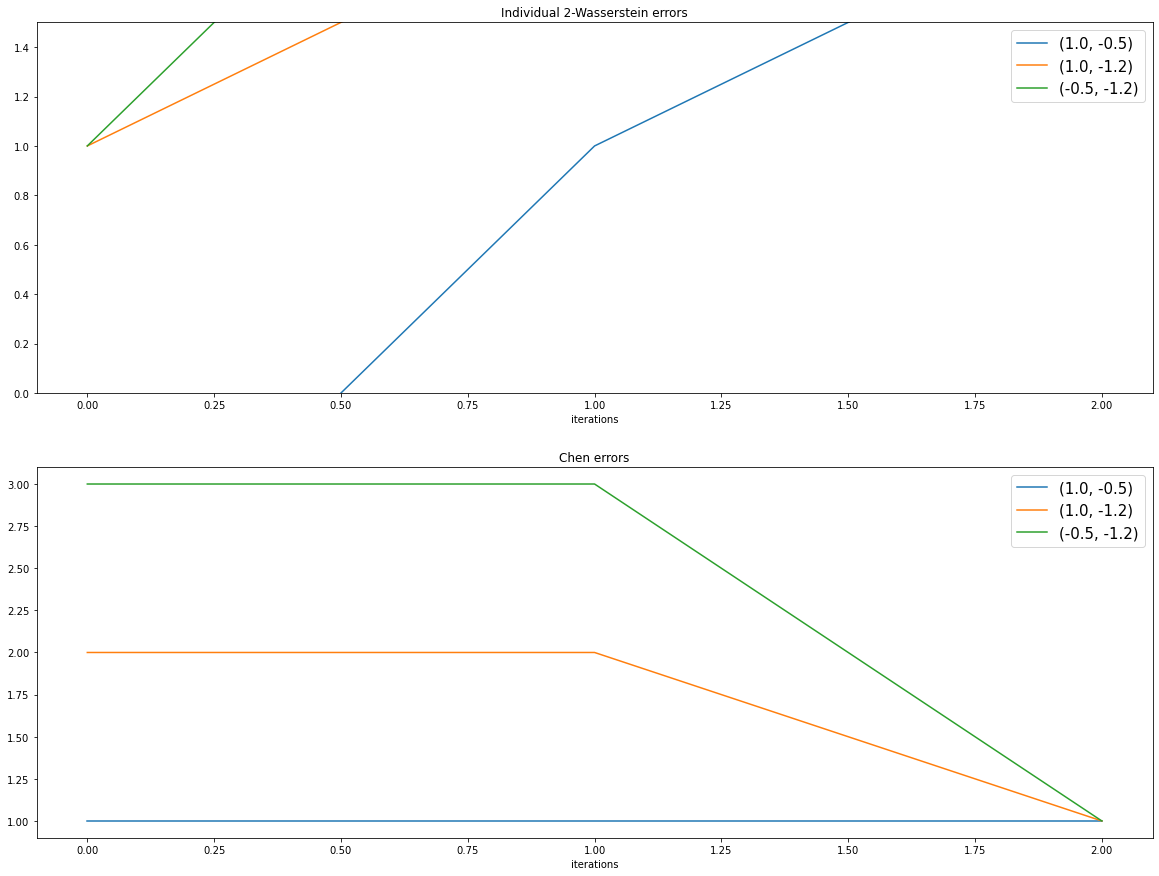

In [5]:
import matplotlib.pyplot as plt
w_dim = 3
labels = list_pairs(w_dim)
wass_errors_through_training = [[-1,1,1],[1,2,3],[2,3,4]]
chen_errors_through_training = [[1,2,3], [1,2,3], [1,1,1]]
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(20,15))
ax1.set_title("Individual 2-Wasserstein errors")
ax1.plot(wass_errors_through_training, label = labels)
ax1.set_ylim([-0.005, 0.2])
ax1.set_xlabel("iterations")
ax1.legend(prop={'size': 15})
ax2.set_title("Chen errors")
ax2.plot(chen_errors_through_training, label = labels)
ax2.set_xlabel("iterations")
ax2.legend(prop={'size': 15})
fig.show()

In [29]:
fig.savefig('out_fig_stuff.png')

In [6]:
w_dim = 4
a_dim = 6


def chen_combine(w_a_in: torch.TensorType):
    # the batch dimension of the inputs will be quartered
    out_size = w_a_in.size(0)//2
    assert 2*out_size == w_a_in.size(0)
    assert w_a_in.size(1) == w_dim + a_dim

    # w_0_s is from 0 to t/2 and w_s_t is from t/2 to t
    w_0_s,w_s_t = w_a_in.chunk(2)
    result = torch.clone(w_0_s + w_s_t)
    result[:,:w_dim] = sqrt(0.5)*result[:,:w_dim]
    result[:,w_dim:(w_dim+a_dim)] = 0.5*result[:,w_dim:(w_dim+a_dim)]

    idx = w_dim
    for k in range(w_dim - 1):
        for l in range(k+1,w_dim):
            correction_term = 0.25*(w_0_s[:,k]*w_s_t[:,l] - w_0_s[:,l]*w_s_t[:,k])
            result[:,idx] += correction_term
            idx += 1

    return result



def chen_error_2step(w_a_in: torch.TensorType):
    combined_data = chen_combine(w_a_in)
    combined_data = chen_combine(combined_data)
    combined_data = chen_combine(combined_data)
    return [sqrt(ot.wasserstein_1d(combined_data[:,w_dim+i],w_a_in[:,w_dim+i],p=2)) for i in range(a_dim)]


In [7]:
# PROOF THAT CHEN RELATION WORKS

w_dim = 4
a_dim = 6
shit_samples = torch.randn((262144,10), dtype=torch.float)
low_prec_samples = torch.tensor(np.genfromtxt('low_prec_samples.csv', dtype=float,delimiter=','))
high_prec_samples = torch.tensor(np.genfromtxt('high_prec_samples.csv', dtype=float,delimiter=','))
print(shit_samples.shape)
print(high_prec_samples.shape)

print(chen_error_2step(shit_samples))
print(chen_error_2step(low_prec_samples))
print(chen_error_2step(high_prec_samples))

torch.Size([262144, 10])
torch.Size([65536, 10])


/home/andy/anaconda3/envs/GAN/lib/python3.10/site-packages/ot/lp/solver_1d.py:41: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484746364/work/aten/src/ATen/native/TensorShape.cpp:2981.)
  cws = cws.T.contiguous()


[0.41826505051808216, 0.4226793462679542, 0.4195580614214039, 0.4158377110257839, 0.4215048473007029, 0.4200040869854577]
[0.10158312908826557, 0.10216402769640108, 0.10356997572708422, 0.09817404280582916, 0.10404973353324538, 0.10118955287648874]
[0.01633234358012648, 0.01760287992997936, 0.019872181878243, 0.01680752610873157, 0.008911869040047132, 0.012170543989985799]


In [8]:
improved_low_prec = low_prec_samples
for i in range(10):
    print(improved_low_prec.shape)
    err = [sqrt(ot.wasserstein_1d(improved_low_prec[:,w_dim+i],high_prec_samples[:,w_dim+i],p=2)) for i in range(a_dim)]
    pretty_err = ["{0:0.5f}".format(i) for i in err]
    print(pretty_err)
    improved_low_prec = chen_combine(improved_low_prec)

torch.Size([524288, 10])
['0.11013', '0.11028', '0.11219', '0.11458', '0.11457', '0.11050']
torch.Size([262144, 10])
['0.05057', '0.04843', '0.05067', '0.05358', '0.05318', '0.04986']
torch.Size([131072, 10])
['0.02475', '0.02271', '0.02295', '0.02824', '0.02522', '0.02398']
torch.Size([65536, 10])
['0.01272', '0.01225', '0.01122', '0.01766', '0.01311', '0.01301']
torch.Size([32768, 10])
['0.01055', '0.01206', '0.01073', '0.01384', '0.01109', '0.01370']
torch.Size([16384, 10])
['0.01178', '0.01128', '0.01265', '0.01510', '0.01129', '0.01640']
torch.Size([8192, 10])
['0.01348', '0.01753', '0.02108', '0.01981', '0.01925', '0.02471']
torch.Size([4096, 10])
['0.02155', '0.01392', '0.03072', '0.02521', '0.01897', '0.04090']
torch.Size([2048, 10])
['0.01774', '0.03060', '0.04047', '0.02391', '0.03276', '0.03484']
torch.Size([1024, 10])
['0.03906', '0.03272', '0.04108', '0.03886', '0.03452', '0.04955']


In [9]:
improved_shit = shit_samples
for i in range(10):
    print(improved_shit.shape)
    err = [sqrt(ot.wasserstein_1d(improved_shit[:,w_dim+i],high_prec_samples[:,w_dim+i],p=2)) for i in range(a_dim)]
    pretty_err = ["{0:0.5f}".format(i) for i in err]
    print(pretty_err)
    improved_shit = chen_combine(improved_shit)

torch.Size([262144, 10])
['0.50962', '0.51490', '0.50857', '0.50662', '0.50998', '0.51460']
torch.Size([131072, 10])
['0.30344', '0.30355', '0.29989', '0.29983', '0.30244', '0.30586']
torch.Size([65536, 10])
['0.17211', '0.17223', '0.16926', '0.16826', '0.17053', '0.17544']
torch.Size([32768, 10])
['0.09378', '0.09343', '0.09100', '0.09183', '0.09063', '0.09577']
torch.Size([16384, 10])
['0.04602', '0.05462', '0.04849', '0.04747', '0.04614', '0.05411']
torch.Size([8192, 10])
['0.03436', '0.03476', '0.02638', '0.02572', '0.02797', '0.03679']
torch.Size([4096, 10])
['0.02396', '0.02797', '0.03414', '0.01899', '0.02042', '0.02804']
torch.Size([2048, 10])
['0.02899', '0.04455', '0.03398', '0.02110', '0.02574', '0.02583']
torch.Size([1024, 10])
['0.04284', '0.04071', '0.03078', '0.06453', '0.03242', '0.02999']
torch.Size([512, 10])
['0.05434', '0.06473', '0.09217', '0.05605', '0.04103', '0.04966']


In [10]:
improved_high_prec = high_prec_samples
for i in range(10):
    print(improved_high_prec.shape)
    err = [sqrt(ot.wasserstein_1d(improved_high_prec[:,w_dim+i],low_prec_samples[:,w_dim+i],p=2)) for i in range(a_dim)]
    pretty_err = ["{0:0.5f}".format(i) for i in err]
    print(pretty_err)
    improved_high_prec = chen_combine(improved_high_prec)

torch.Size([65536, 10])
['0.11013', '0.11028', '0.11219', '0.11458', '0.11457', '0.11050']
torch.Size([32768, 10])
['0.10940', '0.11136', '0.11371', '0.11274', '0.11678', '0.11195']
torch.Size([16384, 10])
['0.10815', '0.11087', '0.11149', '0.11326', '0.11573', '0.10837']
torch.Size([8192, 10])
['0.10895', '0.11332', '0.11582', '0.11853', '0.11645', '0.11405']
torch.Size([4096, 10])
['0.09925', '0.11695', '0.11540', '0.11649', '0.11209', '0.11063']
torch.Size([2048, 10])
['0.08718', '0.10661', '0.13652', '0.10069', '0.12683', '0.11439']
torch.Size([1024, 10])
['0.13742', '0.11974', '0.14895', '0.11271', '0.13350', '0.14872']
torch.Size([512, 10])
['0.12666', '0.10743', '0.18267', '0.11199', '0.13543', '0.15180']
torch.Size([256, 10])
['0.15278', '0.15433', '0.18931', '0.13803', '0.11915', '0.16366']
torch.Size([128, 10])
['0.20102', '0.10545', '0.15247', '0.17761', '0.12289', '0.16315']


In [4]:
# Calculate E[ A^2 | W ] = 1/12 * (1 + (W_1)^2 + (W_2)^2)

def true_second_moments(_w):
    _w_dim = len(_w)
    _w_squared = [x*x for x in _w]
    _a_dim = int((_w_dim - 1)*_w_dim/2)
    moms = []
    for k in range(_w_dim):
        for l in range(k+1,_w_dim):
            moms.append((1.0/12.0)*(1.0 + _w_squared[k] + _w_squared[l]))
    assert len(moms) == _a_dim
    return np.diag(moms)


def empirical_second_moments(_a_generated: np.ndarray):

    _batch_dim = _a_generated.shape[0]
    const = 1.0/_batch_dim
    _a_dim = _a_generated.shape[1]
    result = np.zeros((_a_dim,_a_dim))
    for i in range(_a_dim):
        for j in range(i, _a_dim):
            result[i,j] = const * np.dot(_a_generated[:,i], _a_generated[:,j])
            if i != j:
                result[j,i] = result[i,j]

    return result



def avg_st_dev_error(_w, _a_generated):
    difference = np.abs(np.sqrt(true_second_moments(_w)) - np.sqrt(np.abs(empirical_second_moments(_a_generated))))
    return difference.mean()

def empirical_variances(_a_generated):
    return np.diagonal(empirical_second_moments(_a_generated))

In [5]:
w_dim = 5
a_dim = 10
w_fixed = [1.0,-0.5,-1.2,-0.3,0.7]

# test_filename = f"samples/fixed_samples_{w_dim}-dim.csv"
# A_fixed_true = np.genfromtxt(test_filename,dtype=float,delimiter=',',)
# A_fixed_true = A_fixed_true[:,w_dim:(w_dim+a_dim)]
A_fixed_true = np.zeros((10,10))



a = true_second_moments(w_fixed)
b = empirical_second_moments(A_fixed_true)
c = empirical_variances(A_fixed_true)
print(np.diagonal(a))
# print(b)
print(c)
print(avg_st_dev_error(w_fixed,A_fixed_true))

[0.1875     0.28666667 0.17416667 0.2075     0.22416667 0.11166667
 0.145      0.21083333 0.24416667 0.13166667]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.043458536658709475


In [12]:
filename = f'model_saves/blubiran.txt'

with open(filename, 'a+') as summary_file:
    summary_file.seek(0)
    lines = summary_file.read().splitlines()
    if lines == []:
        serial_num = 1
        summary_file.write(str(serial_num))
    else:
        last_line = lines[-1]
        serial_num = int(last_line)

    summary = f" descriptor: " + "report" + f"\n{serial_num + 1}"
    summary_file.write(summary)



FileNotFoundError: samples/non-fixed_samples_4-dim.csv not found.